In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
# %load_ext cudf.pandas
# import pandas as pd
# print(pd)


In [3]:
# Optimizations
# GDAL optimizations
import multiprocessing as mp
import os

cpu_count: int = mp.cpu_count()
num_cores: int = cpu_count - 2
os.environ["GDAL_NUM_THREADS"] = f"{num_cores}"
os.environ["GDAL_CACHEMAX"] = "1024"


## Libraries

In [4]:
# Imports
from pathlib import Path
import pandas as pd
import numpy as np
import riskmapjnr as rmj


## Dask Processing Instance

In [5]:
import dask
from dask.distributed import LocalCluster, Client

cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit="4GB")
geospatial_client = Client(cluster)
geospatial_client


/home/jose/workspace/deforisk-jupyter-nb-v2/.venv/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35597 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:36405' processes=4 threads=8, memory=14.90 GiB>

In [6]:
# from dask.distributed import SpecCluster, Worker, Nanny, Client

# # Define worker specifications with different memory limits
# worker_specs = {
#     "nanny-1": {"cls": Nanny, "options": {"nthreads": 1, "memory_limit": "1GB"}},
#     "worker-1": {"cls": Worker, "options": {"nthreads": 1, "memory_limit": "8GB"}},
#     "worker-2": {"cls": Worker, "options": {"nthreads": 1, "memory_limit": "2GB"}},
#     "worker-3": {"cls": Worker, "options": {"nthreads": 1, "memory_limit": "2GB"}},
#     "worker-4": {"cls": Worker, "options": {"nthreads": 1, "memory_limit": "2GB"}},
#     "worker-5": {"cls": Worker, "options": {"nthreads": 1, "memory_limit": "2GB"}},
# }

# # Create the cluster
# cluster = SpecCluster(
#     workers=worker_specs,
# )

# # Connect client
# geospatial_client = Client(cluster)
# geospatial_client


## Set user parameters

In [8]:
project_name = "test"


In [9]:
forest_source = "gfc"  ##gfc, tmf
tree_cover_threshold = 10
years = [2015, 2020, 2024]
string_years = [str(num) for num in years]


## Connect folders

In [7]:
root_folder: Path = Path.cwd().parent
downloads_folder: Path = root_folder / "data"
downloads_folder.mkdir(parents=True, exist_ok=True)


In [ ]:
project_folder = downloads_folder / project_name
project_folder.mkdir(parents=True, exist_ok=True)
processed_data_folder = project_folder / "data"
processed_data_folder.mkdir(parents=True, exist_ok=True)
plots_folder = project_folder / "plots_dask"
plots_folder.mkdir(parents=True, exist_ok=True)
rmj_bm = project_folder / "rmj_bm_dask"
rmj_bm.mkdir(parents=True, exist_ok=True)


## Forest Files

In [11]:
def list_files_by_extension(folder_path, file_extensions):
    """
    List all files with specified extensions in the given folder.

    Parameters:
    folder_path (str): The path to the folder where you want to search for files.
    file_extensions (list of str): A list of file extensions to search for (e.g., ['.shp', '.tif']).

    Returns:
    list: A list of file paths with the specified extensions.
    """
    matching_files = []
    try:
        # Check if the provided path is a directory
        if os.path.isdir(folder_path):
            # Iterate over all files in the directory
            for filename in os.listdir(folder_path):
                # Construct full file path
                file_path = os.path.join(folder_path, filename)
                # Check if the file has any of the specified extensions
                if any(filename.lower().endswith(ext) for ext in file_extensions):
                    matching_files.append(file_path)
        else:
            print(f"The provided path '{folder_path}' is not a directory.")
    except Exception as e:
        print(f"An error occurred: {e}")
    return matching_files


In [12]:
def filter_files(input_files, filter_words, exclude_words=None):
    """
    Filters a list of files based on include and exclude words.

    Parameters:
        input_files (list): List of file paths to be filtered.
        filter_words (list): Words that must be present in the filenames for inclusion.
        exclude_words (list, optional): Words that must not be present in the filenames for exclusion. Defaults to None.

    Returns:
        list: Filtered list of files.
    """
    # Ensure all words are lowercase for case-insensitive comparison
    filter_words = [word.lower() for word in filter_words]
    exclude_words = [word.lower() for word in (exclude_words or [])]

    filtered_files = [
        file
        for file in input_files
        if all(word in os.path.basename(file).lower() for word in filter_words)
        and not any(
            exclude_word in os.path.basename(file).lower()
            for exclude_word in exclude_words
        )
    ]

    return filtered_files


In [13]:
# List all raster files in the processed data folder
input_raster_files = list_files_by_extension(processed_data_folder, [".tiff", ".tif"])


In [14]:
forest_change_file = filter_files(
    input_raster_files,
    ["forest", "loss", forest_source] + string_years,
    ["distance", "edge"],
)[0]


In [15]:
forest_yearly_files = filter_files(
    input_raster_files, ["forest", forest_source], ["loss", "edge"]
)


In [16]:
forest_edge_files = filter_files(input_raster_files, ["forest", forest_source, "edge"])


In [17]:
raster_subj_file = filter_files(input_raster_files, ["subj"])[0]


## Periods dictionaries

In [18]:
calibration_dict = {
    "period": "calibration",
    "train_period": "calibration",
    "initial_year": years[0],
    "final_year": years[1],
    "defor_value": 1,
    "time_interval": years[1] - years[0],
    "initial_year_forest": filter_files(forest_yearly_files, [str(years[0])])[0],
    "initial_year_forest_edge": filter_files(forest_edge_files, [str(years[0])])[0],
}
validation_dict = {
    "period": "validation",
    "train_period": "calibration",
    "initial_year": years[1],
    "final_year": years[2],
    "defor_value": 1,
    "time_interval": years[2] - years[1],
    "initial_year_forest": filter_files(forest_yearly_files, [str(years[1])])[0],
    "initial_year_forest_edge": filter_files(forest_edge_files, [str(years[1])])[0],
}
historical_dict = {
    "period": "historical",
    "train_period": "historical",
    "initial_year": years[0],
    "final_year": years[2],
    "defor_value": [1, 2],
    "time_interval": years[2] - years[0],
    "initial_year_forest": filter_files(forest_yearly_files, [str(years[0])])[0],
    "initial_year_forest_edge": filter_files(forest_edge_files, [str(years[0])])[0],
}
forecast_dict = {
    "period": "forecast",
    "train_period": "historical",
    "initial_year": years[0],
    "final_year": years[2],
    "defor_value": [1, 2],
    "time_interval": years[2] - years[0],
    "initial_year_forest": filter_files(forest_yearly_files, [str(years[2])])[0],
    "initial_year_forest_edge": filter_files(forest_edge_files, [str(years[2])])[0],
}


## 1 Calculate distance to forest edge

In [19]:
deforestation_thresh = 99.5
deforestation_thresh = 99.5
# max_dist1 = 5000
# max_dist2 = 5000


In [20]:
# Third party imports
import numpy as np
import xarray as xr
import rioxarray
import pandas as pd
from matplotlib import pyplot as plt
import dask.array as da


def dist_edge_threshold_xarray(
    fcc_file,
    defor_values,
    defor_threshold=99.5,
    dist_file="dist_edge.tif",
    dist_bins=np.arange(0, 1080, step=30),
    tab_file_dist="perc_dist.csv",
    fig_file_dist="perc_dist.png",
    figsize=(6.4, 4.8),
    dpi=100,
    dist_file_available=False,
    check_fcc=True,
    verbose=True,
):
    """Computing the percentage of total deforestation as a function of
    the distance to forest edge.

    This function computes the percentage of total deforestation as a
    function of the distance to forest edge. It returns a table with
    the cumulative percentage of deforestation as distance to forest
    edge increases. It also identifies the distance threshold for the
    distance to forest edge so that the deforestation under that
    threshold is >= 99.5 % of the total deforestation in the
    landscape. The function also plots the relationship between the
    percentage of deforestation and the distance to forest edge. A
    raster of distance to forest edge will be created. The distance
    unit will be the one of the input file.

    :param fcc_file: Input raster file of forest cover change at three
        dates (123). 1: first period deforestation, 2: second period
        deforestation, 3: remaining forest at the end of the second
        period. No data value must be 0 (zero). The raster must be
        projected to compute Euclidean distances with the
        ``gdal_proximity()`` function.

    :param defor_values: Raster values to consider for
        deforestation. Must correspond to either scalar 1 if first
        period, or list [1, 2] if both first and second period are
        considered.

    :param defor_threshold: Deforestation threshold (in
        percent). Default to 99.5.

    :param dist_file: Path to either (i) the output raster file of
        distance to forest edge or (ii) the input raster file of
        distance to forest edge if ``dist_file_available`` is
        ``True``. Raster of distance to forest edge is computed in the
        first case only. Default to ``dist_edge.tif``.

    :param dist_bins: Array of bins for distances. It has to be
        1-dimensional and monotonic. The array must also include zero
        as the first value. Default to ``np.arange(0, 1080,
        step=30)``.

    :param tab_file_dist: Path to the table ``.csv`` file that will be
        created. This table includes the following variables:

        * ``distance``: bins of distance to forest edge (in m).
        * ``npix``: the number of deforested pixels in each bin.
        * ``area``: the corresponding area (in ha).
        * ``cum``: the cumulative sum of the deforested area (in ha).
        * ``perc``: the corresponding percentage of total deforestation.

    :param fig_file_dist: Path to the plot file that will be
        created. This plot represents the cumulative deforestation
        percentage as the distance to forest edge increases.

    :param figsize: Figure size.

    :param dpi: Resolution for output image.

    :param dist_file_available: Boolean. If ``True``, parameter
        ``dist_file`` indicates the input raster file of distance to
        forest edge which is not computed. Default to ``False``.

    :param check_fcc: Boolean. If ``True``, performs some checks on
        the fcc input file. Default to ``True``.

    :param verbose: Logical. Whether to print messages or not. Default
        to ``True``.

    :return: A dictionary. With ``tot_def``: total deforestation (in
        ha), ``dist_thresh``: the distance threshold, ``perc``: the
        percentage of deforestation for pixels with distance <=
        dist_thresh.

    """

    # Read rasters using rioxarray with chunking
    dist_ds: xr.Dataset | xr.DataArray | list[Dataset] = rioxarray.open_rasterio(
        dist_file, chunks=True
    )
    fcc_ds = rioxarray.open_rasterio(fcc_file, chunks=True)

    # Ensure both are dask arrays for parallel processing
    if not isinstance(dist_ds.data, da.Array):
        dist_ds = dist_ds.chunk((dist_ds.sizes["y"], dist_ds.sizes["x"]))
    if not isinstance(fcc_ds.data, da.Array):
        fcc_ds = fcc_ds.chunk((fcc_ds.sizes["y"], fcc_ds.sizes["x"]))

    # Create a table to save the results
    data = {"distance": dist_bins[1:], "npix": 0, "area": 0.0, "cum": 0.0, "perc": 0.0}
    res_df = pd.DataFrame(data)

    # Total deforested pixels
    npix_def = 0

    # Process all chunks in parallel using dask
    # Convert to numpy arrays for processing (this will trigger computation)
    dist_data_full = dist_ds.values
    fcc_data_full = fcc_ds.values

    # Get pixel area from geotransform
    gt = dist_ds.rio.transform()
    pix_area = abs(gt[0]) * abs(gt[4])  # Pixel area in projection units squared

    # Process data in chunks using dask's parallel processing capabilities
    def process_chunk(dist_chunk, fcc_chunk):
        """Process a single chunk of data."""
        # Number of deforested pixels
        if isinstance(defor_values, int):
            defor_values_array = [defor_values]
        else:
            defor_values_array = defor_values

        npix_def_chunk = np.isin(fcc_chunk, defor_values_array).sum()

        # Consider only deforested pixels for distances
        dist_def = dist_chunk * np.isin(fcc_chunk, defor_values_array)
        dist_def = dist_def[dist_def > 0]

        # Categorize distance and count by bin
        if len(dist_def) > 0:
            dist_cat = pd.cut(dist_def.flatten(), dist_bins, right=True)
            df = pd.DataFrame({"dist": dist_cat})
            counts = df.groupby(df.dist, observed=False).size()
        else:
            counts = pd.Series(dtype="int64")

        return npix_def_chunk, counts

    # Process all chunks
    if verbose:
        print("Processing raster data in chunks...")

    # Since we're using dask arrays, we can compute chunk-wise operations
    # For simplicity and efficiency, let's process the entire dataset at once for this operation

    # Create masks for deforested pixels
    if isinstance(defor_values, int):
        defor_values_array = [defor_values]
    else:
        defor_values_array = defor_values

    # Process data in a chunked way using dask's lazy evaluation
    # We'll compute the whole dataset to avoid memory issues with large rasters
    dist_data = dist_ds.values
    fcc_data = fcc_ds.values

    # Count total deforested pixels
    npix_def = np.isin(fcc_data, defor_values_array).sum()

    # Get deforested distances
    dist_def = dist_data * np.isin(fcc_data, defor_values_array)
    dist_def = dist_def[dist_def > 0]

    # Categorize distance and count by bin
    if len(dist_def) > 0:
        dist_cat = pd.cut(dist_def.flatten(), dist_bins, right=True)
        df = pd.DataFrame({"dist": dist_cat})
        counts = df.groupby(df.dist, observed=False).size()

        # Update data-frame
        res_df.loc[:, "npix"] = counts.values

    # Compute deforested areas
    area = res_df["npix"].values * pix_area / 10000  # Convert to hectares
    res_df.loc[:, "area"] = area
    tot_area_def = npix_def * pix_area / 10000

    # Cumulated deforestation
    res_df.loc[:, "cum"] = res_df["area"].cumsum().values

    # Percentage of total deforestation
    res_df.loc[:, "perc"] = 100 * res_df["cum"].values / tot_area_def

    # Export the table of results
    res_df.to_csv(tab_file_dist, sep=",", header=True, index=False, index_label=False)

    # Distance and percentage for deforestation threshold
    try:
        index_thresh = np.nonzero(res_df["perc"].values > defor_threshold)[0][0]
    except IndexError:
        raise ValueError("Increase maximal distance defined in argument 'dist_bins'.")

    dist_thresh = res_df.loc[index_thresh, "distance"]
    perc_thresh = np.around(res_df.loc[index_thresh, "perc"], 2)

    # Plot
    fig = plt.figure(figsize=figsize, dpi=dpi)
    plt.subplot(111)
    plt.plot(res_df["distance"], res_df["perc"], "b-")
    plt.vlines(
        dist_thresh,
        ymin=np.min(res_df["perc"]),
        ymax=perc_thresh,
        colors="k",
        linestyles="dashed",
    )
    plt.hlines(perc_thresh, xmin=0, xmax=dist_thresh, colors="k", linestyles="dashed")
    plt.xlabel("Distance to forest edge (m)")
    plt.ylabel("Percentage of total deforestation (%)")
    # Text distance
    t1 = str(dist_thresh) + " m"
    x1_text = dist_thresh - 0.01 * np.max(dist_bins)
    y1_text = np.min(res_df["perc"])
    plt.text(x1_text, y1_text, t1, ha="right", va="bottom")
    # Text percentage
    t2 = str(perc_thresh) + " %"
    x2_text = 0
    y2_text = perc_thresh - 0.01 * (100 - np.min(res_df["perc"]))
    plt.text(x2_text, y2_text, t2, ha="left", va="top")
    fig.savefig(fig_file_dist)
    plt.close(fig)

    # Results
    return {
        "tot_def": tot_area_def,
        "dist_thresh": dist_thresh,
        "perc_thresh": perc_thresh,
    }


In [21]:
# Third party imports
import numpy as np
import xarray as xr
import rioxarray
import pandas as pd
from matplotlib import pyplot as plt
import dask.array as da


def dist_edge_threshold_xarray_v2(
    fcc_file,
    defor_values,
    defor_threshold=99.5,
    dist_file="dist_edge.tif",
    tab_file_dist="perc_dist.csv",
    fig_file_dist="perc_dist.png",
    figsize=(6.4, 4.8),
    dpi=100,
    dist_file_available=False,
    check_fcc=True,
    verbose=True,
):
    """Computing the percentage of total deforestation as a function of
    the distance to forest edge.

    This function computes the percentage of total deforestation as a
    function of the distance to forest edge. It returns a table with
    the cumulative percentage of deforestation as distance to forest
    edge increases. It also identifies the distance threshold for the
    distance to forest edge so that the deforestation under that
    threshold is >= 99.5 % of the total deforestation in the
    landscape. The function also plots the relationship between the
    percentage of deforestation and the distance to forest edge. A
    raster of distance to forest edge will be created. The distance
    unit will be the one of the input file.

    :param fcc_file: Input raster file of forest cover change at three
        dates (123). 1: first period deforestation, 2: second period
        deforestation, 3: remaining forest at the end of the second
        period. No data value must be 0 (zero). The raster must be
        projected to compute Euclidean distances with the
        ``gdal_proximity()`` function.

    :param defor_values: Raster values to consider for
        deforestation. Must correspond to either scalar 1 if first
        period, or list [1, 2] if both first and second period are
        considered.

    :param defor_threshold: Deforestation threshold (in
        percent). Default to 99.5.

    :param dist_file: Path to either (i) the output raster file of
        distance to forest edge or (ii) the input raster file of
        distance to forest edge if ``dist_file_available`` is
        ``True``. Raster of distance to forest edge is computed in the
        first case only. Default to ``dist_edge.tif``.

    :param tab_file_dist: Path to the table ``.csv`` file that will be
        created. This table includes the following variables:

        * ``distance``: bins of distance to forest edge (in m).
        * ``npix``: the number of deforested pixels in each bin.
        * ``area``: the corresponding area (in ha).
        * ``cum``: the cumulative sum of the deforested area (in ha).
        * ``perc``: the corresponding percentage of total deforestation.

    :param fig_file_dist: Path to the plot file that will be
        created. This plot represents the cumulative deforestation
        percentage as the distance to forest edge increases.

    :param figsize: Figure size.

    :param dpi: Resolution for output image.

    :param dist_file_available: Boolean. If ``True``, parameter
        ``dist_file`` indicates the input raster file of distance to
        forest edge which is not computed. Default to ``False``.

    :param check_fcc: Boolean. If ``True``, performs some checks on
        the fcc input file. Default to ``True``.

    :param verbose: Logical. Whether to print messages or not. Default
        to ``True``.

    :return: A dictionary. With ``tot_def``: total deforestation (in
        ha), ``dist_thresh``: the distance threshold, ``perc``: the
        percentage of deforestation for pixels with distance <=
        dist_thresh.

    """

    # Read rasters using rioxarray with chunking
    dist_ds = rioxarray.open_rasterio(dist_file, chunks=True)
    fcc_ds = rioxarray.open_rasterio(fcc_file, chunks=True)

    # Ensure both are dask arrays for parallel processing
    if not isinstance(dist_ds.data, da.Array):
        dist_ds = dist_ds.chunk((dist_ds.sizes["y"], dist_ds.sizes["x"]))
    if not isinstance(fcc_ds.data, da.Array):
        fcc_ds = fcc_ds.chunk((fcc_ds.sizes["y"], fcc_ds.sizes["x"]))

    # Get pixel area from geotransform
    gt = dist_ds.rio.transform()
    pix_res = abs(gt[0])  # Pixel resolution in the same units as distance

    # Compute max distance in raster
    dist_data_full = dist_ds.values
    valid_distances = dist_data_full[dist_data_full > 0]
    max_dist = np.max(valid_distances) if len(valid_distances) > 0 else 0

    # Define bins dynamically
    dist_bins = np.arange(0, max_dist + pix_res, step=pix_res)

    # Create a table to save the results
    data = {"distance": dist_bins[1:], "npix": 0, "area": 0.0, "cum": 0.0, "perc": 0.0}
    res_df = pd.DataFrame(data)

    # Total deforested pixels
    npix_def = 0

    # Process all chunks in parallel using dask
    dist_data = dist_ds.values
    fcc_data = fcc_ds.values

    # Get pixel area from geotransform
    pix_area = abs(gt[0]) * abs(gt[4])

    # Create masks for deforested pixels
    if isinstance(defor_values, int):
        defor_values_array = [defor_values]
    else:
        defor_values_array = defor_values

    # Count total deforested pixels
    npix_def = np.isin(fcc_data, defor_values_array).sum()

    # Get deforested distances
    dist_def = dist_data * np.isin(fcc_data, defor_values_array)
    dist_def = dist_def[dist_def > 0]

    # Categorize distance and count by bin
    if len(dist_def) > 0:
        dist_cat = pd.cut(dist_def.flatten(), dist_bins, right=True)
        df = pd.DataFrame({"dist": dist_cat})
        counts = df.groupby(df.dist, observed=False).size()

        # Update data-frame
        res_df.loc[:, "npix"] = counts.values

    # Compute deforested areas
    area = res_df["npix"].values * pix_area / 10000  # Convert to hectares
    res_df.loc[:, "area"] = area
    tot_area_def = npix_def * pix_area / 10000

    # Cumulated deforestation
    res_df.loc[:, "cum"] = res_df["area"].cumsum().values

    # Percentage of total deforestation
    res_df.loc[:, "perc"] = 100 * res_df["cum"].values / tot_area_def

    # Export the table of results
    res_df.to_csv(tab_file_dist, sep=",", header=True, index=False, index_label=False)

    # Distance and percentage for deforestation threshold
    try:
        index_thresh = np.nonzero(res_df["perc"].values > defor_threshold)[0][0]
    except IndexError:
        raise ValueError("Increase maximal distance defined in argument 'dist_bins'.")

    dist_thresh = res_df.loc[index_thresh, "distance"]
    perc_thresh = np.around(res_df.loc[index_thresh, "perc"], 2)

    # Plot
    fig = plt.figure(figsize=figsize, dpi=dpi)
    plt.subplot(111)
    plt.plot(res_df["distance"], res_df["perc"], "b-")
    plt.vlines(
        dist_thresh,
        ymin=np.min(res_df["perc"]),
        ymax=perc_thresh,
        colors="k",
        linestyles="dashed",
    )
    plt.hlines(perc_thresh, xmin=0, xmax=dist_thresh, colors="k", linestyles="dashed")
    plt.xlabel("Distance to forest edge (m)")
    plt.ylabel("Percentage of total deforestation (%)")
    # Text distance
    t1 = str(dist_thresh) + " m"
    x1_text = dist_thresh - 0.01 * np.max(dist_bins)
    y1_text = np.min(res_df["perc"])
    plt.text(x1_text, y1_text, t1, ha="right", va="bottom")
    # Text percentage
    t2 = str(perc_thresh) + " %"
    x2_text = 0
    y2_text = perc_thresh - 0.01 * (100 - np.min(res_df["perc"]))
    plt.text(x2_text, y2_text, t2, ha="left", va="top")
    fig.savefig(fig_file_dist)
    plt.close(fig)

    # Results
    return {
        "tot_def": tot_area_def,
        "dist_thresh": dist_thresh,
        "perc_thresh": perc_thresh,
    }


In [22]:
def calculate_period_dist_edge_threshold(
    forest_change_file,
    period_dictionary,
    deforestation_thresh,
    model_folder,
    plots_folder,
):
    period_output_folder = model_folder / period_dictionary["period"]
    if not os.path.exists(period_output_folder):
        os.makedirs(period_output_folder)
    # dist_thresh = rmj.dist_edge_threshold(
    dist_thresh = dist_edge_threshold_xarray_v2(
        fcc_file=forest_change_file,
        defor_values=period_dictionary["defor_value"],
        defor_threshold=deforestation_thresh,
        dist_file=period_dictionary["initial_year_forest_edge"],
        # dist_bins=np.arange(0, max_dist, step=30),
        tab_file_dist=period_output_folder / "tab_dist.csv",
        fig_file_dist=plots_folder / f"perc_dist_{period_dictionary['period']}.png",
        # blk_rows=128,
        dist_file_available=True,
        check_fcc=True,
        verbose=True,
    )
    # Save result
    dist_edge_data = pd.DataFrame(dist_thresh, index=[0])
    dist_edge_data.to_csv(
        period_output_folder / "dist_edge_threshold.csv",
        sep=",",
        header=True,
        index=False,
        index_label=False,
    )


In [23]:
calculate_period_dist_edge_threshold(
    forest_change_file,
    calibration_dict,
    deforestation_thresh,
    rmj_bm,
    plots_folder,
)


In [24]:
calculate_period_dist_edge_threshold(
    forest_change_file,
    calibration_dict,
    deforestation_thresh,
    rmj_bm,
    plots_folder,
)


In [25]:
calculate_period_dist_edge_threshold(
    forest_change_file,
    historical_dict,
    deforestation_thresh,
    rmj_bm,
    plots_folder,
)


## 2 Compute bins

In [26]:
def get_dist_thresh(ifile):
    """Get distance to forest edge threshold."""
    dist_thresh_data = pd.read_csv(ifile)
    dist_thresh = dist_thresh_data.loc[0, "dist_thresh"]
    return dist_thresh


def save_dist_bins(dist_bins, output_file):
    dist_bins_str = [str(i) for i in dist_bins]
    with open(output_file, "w", encoding="utf-8") as f:
        f.write("\n".join(dist_bins_str))


def get_dist_bins(dist_bins_file):
    """Get distance bins."""
    with open(dist_bins_file, "r", encoding="utf-8") as f:
        dist_bins = [float(line.rstrip()) for line in f]
    return dist_bins


In [27]:
"""
Compute distance bins using rioxarray and dask.
"""

# Third party imports
import numpy as np
import rioxarray
import math


def compute_dist_bins(dist_file, dist_thresh):
    """Compute distance bins.

    A geometric classification is used to convert distance to
    forest edge into vulnerability classes.

    :param dist_file: Distance to forest edge file.
    :param dist_thresh: Distance threshold.

    """

    # Read the distance raster using rioxarray
    dist_ds = rioxarray.open_rasterio(dist_file, chunks=True)

    # Get geotransform information
    gt = dist_ds.rio.transform()
    xres = abs(gt[0])  # Absolute value of x-resolution
    yres = abs(gt[4])  # Absolute value of y-resolution

    # Get minimum resolution
    dist_min = min(xres, yres)

    # Number of classes for geometric classification
    n_classes = 29

    # Calculate the ratio for geometric progression
    ratio = math.pow(dist_min / dist_thresh, 1 / n_classes)

    # Generate bins using geometric progression
    bins = [dist_thresh * math.pow(ratio, n_classes - i) for i in range(n_classes + 1)]

    # Correction for dist_min (as in original function)
    bins[0] = dist_min

    return bins


In [28]:
def calculate_period_dist_bins(period_dictionary, model_folder):
    period_output_folder = model_folder / period_dictionary["period"]
    period_dist_edge_file = period_output_folder / "dist_edge_threshold.csv"
    # dist_bins = rmj.benchmark.compute_dist_bins(
    dist_bins = compute_dist_bins(
        period_dictionary.get("initial_year_forest_edge"),
        get_dist_thresh(period_dist_edge_file),
    )
    dist_thresh = get_dist_thresh(period_dist_edge_file)
    dist_bins_file = period_output_folder / "dist_bins.csv"
    save_dist_bins(dist_bins, dist_bins_file)


In [29]:
calculate_period_dist_bins(calibration_dict, rmj_bm)


In [30]:
calculate_period_dist_bins(historical_dict, rmj_bm)


## 3 Compute vulnerability map

In [31]:
"""
Map with vulnerability classes using rioxarray and dask.
"""

import os
import numpy as np
import xarray as xr
import rioxarray
import pandas as pd


def vulnerability_map_xarray(
    forest_file,
    dist_file,
    dist_bins,
    subj_file,
    output_file="vulnerability_map.tif",
    blk_rows=128,
    verbose=True,
):
    """Map with vulnerability classes.

    A raster file with vulnerability classes is created combining distance
    to forest edge classes and subjurisdiction identifiers. High
    values indicate higher vulnerability. Raster type is UInt16 ([0,
    65535]). NoData value is set to 0.

    :param forest_file: Input forest cover file. Necessary to have
        forest extent within country borders (info not provided by
        dist_file).

    :param dist_file: Input file of distance to forest edge.

    :param dist_bins: The distance bins used to convert distance to
        forest edge into vulnerability classes. The first value
        indicates the minimal distance and the last value indicates
        the distance threshold.

    :param subj_file: Input raster file with subjurisdiction
        identifiers.

    :param blk_rows: If > 0, number of rows for computation by block.

    :param verbose: Logical. Whether to print messages or not. Default
        to ``True``.

    :return: Bins used to categorize the deforestation risk based on
        the distance to forest edge.

    """

    # ==============================================================
    # Input rasters
    # ==============================================================

    # Read all input files with chunking for large datasets
    forest_ds = rioxarray.open_rasterio(forest_file, chunks=True)
    dist_ds = rioxarray.open_rasterio(dist_file, chunks=True)
    subj_ds = rioxarray.open_rasterio(subj_file, chunks=True)

    # Distance info from bins
    n_classes = len(dist_bins) - 1
    dist_thresh = dist_bins[-1]

    # =================================================
    # Categorical raster file for vulnerability classes
    # =================================================

    # Get the first band of each dataset (assuming single band)
    forest_data = forest_ds.squeeze()
    dist_data = dist_ds.squeeze()
    subj_data = subj_ds.squeeze()

    # Categorize distance to forest edge using pandas cut function
    # Convert to numpy arrays for processing (this will trigger computation)
    dist_array = dist_data.values
    forest_array = forest_data.values
    subj_array = subj_data.values

    # Categorize using pandas cut function
    # cat_data = pd.cut(
    #     dist_array.flatten(),
    #     bins=dist_bins,
    #     labels=False,
    #     include_lowest=True,
    #     right=True,
    # )
    # cat_data = cat_data.reshape(dist_array.shape)

    # With a more direct NumPy approach:
    cat_data = np.digitize(dist_array, dist_bins, right=True)

    # Reverse the category order (higher vulnerability = higher class)
    cat_data = n_classes + 1 - cat_data

    # Set classes 1 beyond distance threshold
    cat_data[dist_array > dist_thresh] = 1
    cat_data[forest_array == 0] = 0  # Mask with forest

    # Add subjurisdiction info
    cat_data = cat_data * 1000 + subj_array
    cat_data[cat_data <= 1000] = 0

    # Create output dataset with same dimensions and metadata
    output_da = xr.full_like(forest_data, 0, dtype="uint16")
    output_da.values = cat_data.astype("uint16")

    # Set NoData value explicitly to match GDAL behavior
    output_da.rio.write_nodata(0, inplace=True)

    # Save the output file using rioxarray's efficient raster writing capabilities
    from dask.distributed import Lock

    output_da.rio.to_raster(
        output_file,
        driver="GTiff",
        compress="DEFLATE",
        predictor=2,
        bigtiff="YES",
        tiled=True,
        lock=Lock("rio"),
    )

    # Return bins used (same as original function)
    return dist_bins


In [32]:
def calculate_period_vulnerability_map(
    period_dictionary, raster_subj_file, model_folder
):
    period_output_folder = model_folder / period_dictionary["period"]
    if not os.path.exists(period_output_folder):
        os.makedirs(period_output_folder)
    trained_period_output_folder = model_folder / period_dictionary["train_period"]
    dist_bins_file = trained_period_output_folder / "dist_bins.csv"
    vulnerability_map_file = (
        period_output_folder / f"prob_bm_{period_dictionary['period']}.tif"
    )

    # rmj.benchmark.vulnerability_map(
    vulnerability_map_xarray(
        forest_file=period_dictionary["initial_year_forest"],
        dist_file=period_dictionary["initial_year_forest_edge"],
        dist_bins=get_dist_bins(dist_bins_file),
        subj_file=raster_subj_file,
        output_file=vulnerability_map_file,
        blk_rows=128,
        verbose=False,
    )


In [33]:
calculate_period_vulnerability_map(calibration_dict, raster_subj_file, rmj_bm)


In [34]:
calculate_period_vulnerability_map(historical_dict, raster_subj_file, rmj_bm)


In [35]:
calculate_period_vulnerability_map(validation_dict, raster_subj_file, rmj_bm)


In [36]:
calculate_period_vulnerability_map(forecast_dict, raster_subj_file, rmj_bm)


## 4 Compute deforestation rate per vulnerability class

In [37]:
"""
Compute deforestation rates per vulnerability class using xarray with Dask.
"""

import numpy as np
import xarray as xr
import rioxarray
import pandas as pd


def defrate_per_class_xarray(
    fcc_file,
    vulnerability_file,
    time_interval,
    period="calibration",
    deforate_model=None,
    tab_file_defrate="defrate_per_class.csv",
    verbose=True,
):
    """
    Compute deforestation rates per vulnerability class using xarray with Dask.

    This function computes the historical deforestation rates for each
    vulnerability class using modern geospatial libraries with parallel processing.

    A ``.csv`` file with deforestation rates for each vulnerability
    class is created (see ``tab_file_defrate``).

    :param fcc_file: Input raster file of forest cover change at three
        dates (123). 1: first period deforestation, 2: second period
        deforestation, 3: remaining forest at the end of the second
        period. No data value must be 0 (zero).

    :param vulnerability_file: Input file with vulnerability classes.

    :param time_interval: Time interval (in years) for forest cover
        change observations.

    :param period: Either "calibration" (from t1 to t2), "validation"
        (or "confirmation" from t2 to t3), or "historical" (full
        historical period from t1 to t3). Default to "calibration".

    :param deforate_model: Path to the ``.csv`` input file with
        deforestation rates per class from the model's period
        (either "calibration" or "historical" period). Used for
        estimating deforestation for the "validation" or "forecast"
        period after quantity adjustment.

    :param tab_file_defrate: Path to the ``.csv`` output file with
        estimates of deforestation rates for each vulnerability class.

    :param verbose: Logical. Whether to print messages or not. Default
        to ``True``.
    """

    # ==============================================================
    # Input rasters using xarray/rioxarray with Dask chunking
    # ==============================================================

    # Open files with rioxarray using Dask chunks for parallel processing
    fcc_ds = rioxarray.open_rasterio(fcc_file, chunks=True)
    defor_cat_ds = rioxarray.open_rasterio(vulnerability_file, chunks=True)

    # Get spatial information
    xres = abs(fcc_ds.rio.resolution()[0])
    yres = abs(fcc_ds.rio.resolution()[1])

    # ==============================================
    # Compute deforestation rates per cat using Dask
    # ==============================================

    # Get unique categories from vulnerability raster (more efficient than hardcoding)
    unique_cats = np.unique(defor_cat_ds.values[defor_cat_ds.values != 0])
    unique_cats = unique_cats[unique_cats > 0]  # Remove 0s if any

    # Create a table to save the results
    data = {"cat": unique_cats, "nfor": 0, "ndefor": 0}
    df = pd.DataFrame(data)

    # Process the entire dataset using Dask for parallel computation
    # This automatically handles chunking and parallel processing

    # Defor data on period - use vectorized operations for efficiency
    if period == "calibration":
        data_for = defor_cat_ds.where(fcc_ds > 0).values.flatten()
        data_defor = defor_cat_ds.where(fcc_ds == 1).values.flatten()
    elif period == "validation":
        data_for = defor_cat_ds.where(fcc_ds > 1).values.flatten()
        data_defor = defor_cat_ds.where(fcc_ds == 2).values.flatten()
    else:  # historical or forecast
        data_for = defor_cat_ds.where(fcc_ds > 0).values.flatten()
        data_defor = defor_cat_ds.where((fcc_ds == 1) | (fcc_ds == 2)).values.flatten()

    # Remove NaN values (which represent no-data areas)
    data_for = data_for[~np.isnan(data_for)]
    data_defor = data_defor[~np.isnan(data_defor)]

    # Count occurrences by category using pandas for efficiency
    # Convert to Series and use value_counts for better performance
    cat_for_series = pd.Series(data_for.astype(int))
    cat_defor_series = pd.Series(data_defor.astype(int))

    # Get counts for each category
    nfor_counts = cat_for_series.value_counts()
    ndefor_counts = cat_defor_series.value_counts()

    # Update the DataFrame with actual counts
    for cat in unique_cats:
        df.loc[df["cat"] == cat, "nfor"] = nfor_counts.get(cat, 0)
        df.loc[df["cat"] == cat, "ndefor"] = ndefor_counts.get(cat, 0)

    # Remove classes with no forest
    df = df[df["nfor"] != 0]

    # Annual deforestation rates per category (just for info)
    df["rate_obs"] = 1 - (1 - df["ndefor"] / df["nfor"]) ** (1 / time_interval)

    # Relative deforestation rate from model (not annual)
    if period in ["validation", "forecast"]:
        df_mod = pd.read_csv(deforate_model)
        # Join the tables to get rate_mod.
        df = df.merge(right=df_mod, on="cat", how="left", suffixes=(None, "_mod"))
    else:
        df["rate_mod"] = df["ndefor"] / df["nfor"]

    # Correction factor, either ndefor / sum_i p_i
    # or theta * nfor / sum_i p_i
    sum_ndefor = df["ndefor"].sum()
    sum_pi = (df["nfor"] * df["rate_mod"]).sum()
    correction_factor = sum_ndefor / sum_pi

    # Absolute deforestation probability
    # With quantity adjustment
    df["rate_abs"] = df["rate_mod"] * correction_factor

    # Time interval
    df["time_interval"] = time_interval

    # Pixel area
    pixel_area = xres * yres / 10000
    df["pixel_area"] = pixel_area

    # Deforestation density (ha/pixel/yr)
    df["defor_dens"] = df["rate_abs"] * pixel_area / time_interval

    # Export the table of results
    df.to_csv(tab_file_defrate, sep=",", header=True, index=False, index_label=False)

    # Clean up - in xarray this is handled automatically but good to be explicit
    fcc_ds.close()
    defor_cat_ds.close()


In [38]:
def defrate_per_class_xarray_v2(
    fcc_file,
    vulnerability_file,
    time_interval,
    period="calibration",
    deforate_model=None,
    tab_file_defrate="defrate_per_class.csv",
):
    """
    Final optimized implementation with minimal pandas usage.
    """

    # Open files with rioxarray
    fcc_ds = rioxarray.open_rasterio(fcc_file, chunks=True)
    defor_cat_ds = rioxarray.open_rasterio(vulnerability_file, chunks=True)

    # Get spatial information
    xres = abs(fcc_ds.rio.resolution()[0])
    yres = abs(fcc_ds.rio.resolution()[1])

    # Convert to dask arrays for computation
    fcc_da = fcc_ds.data
    defor_cat_da = defor_cat_ds.data

    # Get unique categories efficiently using Dask
    unique_cats = da.unique(defor_cat_da[defor_cat_da != 0]).compute()
    unique_cats = unique_cats[unique_cats > 0]

    # Process based on period
    if period == "calibration":
        data_for_mask = fcc_da > 0
        data_defor_mask = fcc_da == 1
    elif period == "validation":
        data_for_mask = fcc_da > 1
        data_defor_mask = fcc_da == 2
    else:  # historical or forecast
        data_for_mask = fcc_da > 0
        data_defor_mask = (fcc_da == 1) | (fcc_da == 2)

    # Apply masks using dask where function and flatten
    data_for = da.where(data_for_mask, defor_cat_da, np.nan).flatten()
    data_defor = da.where(data_defor_mask, defor_cat_da, np.nan).flatten()

    # Remove NaN values and count efficiently
    valid_for = data_for[~da.isnan(data_for)]
    valid_defor = data_defor[~da.isnan(data_defor)]

    # Count categories (this is where we use pandas but only for final result)
    # Convert back to numpy arrays for counting with pandas
    nfor_counts = pd.Series(valid_for.compute().astype(int)).value_counts()
    ndefor_counts = pd.Series(valid_defor.compute().astype(int)).value_counts()

    # Create results DataFrame (minimal pandas usage)
    data = {
        "cat": unique_cats,
        "nfor": [nfor_counts.get(cat, 0) for cat in unique_cats],
        "ndefor": [ndefor_counts.get(cat, 0) for cat in unique_cats],
    }
    df = pd.DataFrame(data)

    # Remove classes with no forest
    df = df[df["nfor"] != 0]

    # Continue with remaining computations
    df["rate_obs"] = 1 - (1 - df["ndefor"] / df["nfor"]) ** (1 / time_interval)

    if period in ["validation", "forecast"]:
        df_mod = pd.read_csv(deforate_model)
        df = df.merge(right=df_mod, on="cat", how="left", suffixes=(None, "_mod"))
    else:
        df["rate_mod"] = df["ndefor"] / df["nfor"]

    sum_ndefor = df["ndefor"].sum()
    sum_pi = (df["nfor"] * df["rate_mod"]).sum()
    correction_factor = sum_ndefor / sum_pi

    df["rate_abs"] = df["rate_mod"] * correction_factor
    df["time_interval"] = time_interval

    pixel_area = xres * yres / 10000
    df["pixel_area"] = pixel_area
    df["defor_dens"] = df["rate_abs"] * pixel_area / time_interval

    # Export results
    df.to_csv(tab_file_defrate, sep=",", header=True, index=False, index_label=False)

    fcc_ds.close()
    defor_cat_ds.close()


In [39]:
def calculate_period_vulnerability_classes(
    period_dictionary, forest_change_file, model_folder
):
    period_output_folder = model_folder / period_dictionary["period"]
    trained_period_output_folder = model_folder / period_dictionary["train_period"]
    vulnerability_file_path = (
        period_output_folder / f"prob_bm_{period_dictionary['period']}.tif"
    )
    time_interval = period_dictionary["time_interval"]
    if period_dictionary["period"] in ["validation", "forecast"]:
        deforate_model = (
            trained_period_output_folder
            / f"defrate_cat_bm_{period_dictionary['train_period']}.csv"
        )
    else:
        deforate_model = None
    output_file = (
        period_output_folder / f"defrate_cat_bm_{period_dictionary['period']}.csv"
    )
    # rmj.benchmark.defrate_per_class(
    defrate_per_class_xarray_v2(
        fcc_file=forest_change_file,
        vulnerability_file=vulnerability_file_path,
        time_interval=period_dictionary["time_interval"],
        period=period_dictionary["period"],
        deforate_model=deforate_model,
        tab_file_defrate=output_file,
        # blk_rows=128,
        # verbose=False,
    )


In [40]:
calculate_period_vulnerability_classes(calibration_dict, forest_change_file, rmj_bm)


In [41]:
calculate_period_vulnerability_classes(historical_dict, forest_change_file, rmj_bm)


In [42]:
calculate_period_vulnerability_classes(validation_dict, forest_change_file, rmj_bm)


In [43]:
calculate_period_vulnerability_classes(forecast_dict, forest_change_file, rmj_bm)


## 5 Plot Risk map of deforestation

In [44]:
input_vector_files = list_files_by_extension(processed_data_folder, [".shp"])
aoi_vector = filter_files(input_vector_files, ["aoi"])[0]


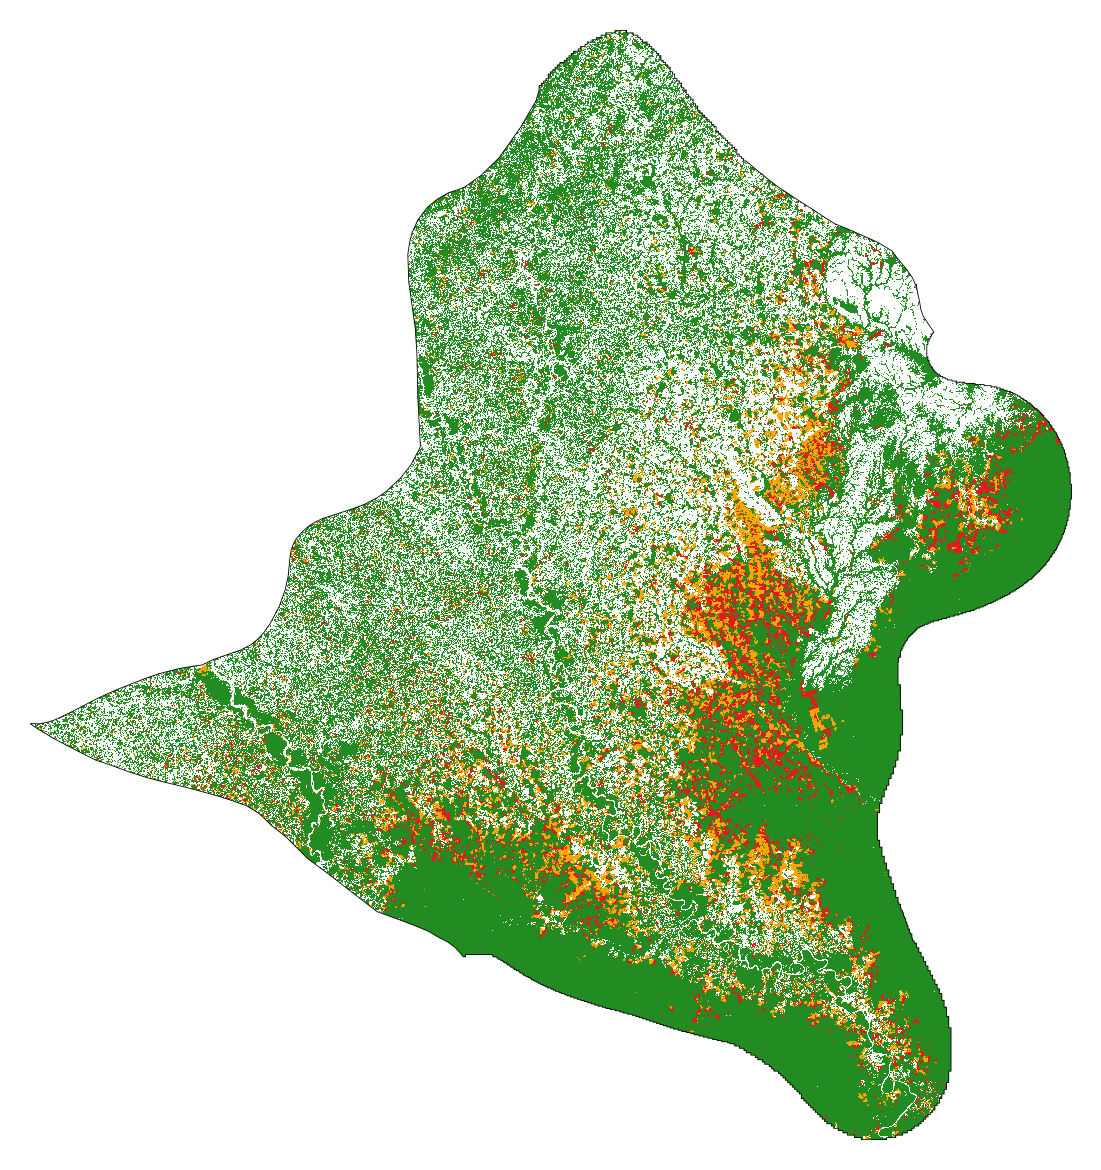

In [45]:
fcc_plot = os.path.join(plots_folder, "fcc123.png")
fig_fcc123 = rmj.plot.fcc123(
    input_fcc_raster=forest_change_file,
    maxpixels=1e8,
    output_file=fcc_plot,
    borders=aoi_vector,
    linewidth=0.2,
    figsize=(5, 4),
    dpi=300,
)


In [46]:
def calculate_period_plot_risk_map(
    period_dictionary, aoi_vector, model_folder, plots_folder
):
    period_output_folder = model_folder / period_dictionary["period"]
    ifile = str(period_output_folder / f"prob_bm_{period_dictionary['period']}.tif")
    # ofile = period_output_folder /  f"prob_bm_{period_dictionary['period']}.png
    ofile = str(plots_folder / f"prob_bm_{period_dictionary['period']}.png")
    riskmap_fig = rmj.benchmark.plot.vulnerability_map(
        input_map=ifile,
        maxpixels=1e8,
        output_file=ofile,
        borders=aoi_vector,
        legend=True,
        figsize=(6, 5),
        dpi=300,
        linewidth=0.3,
    )


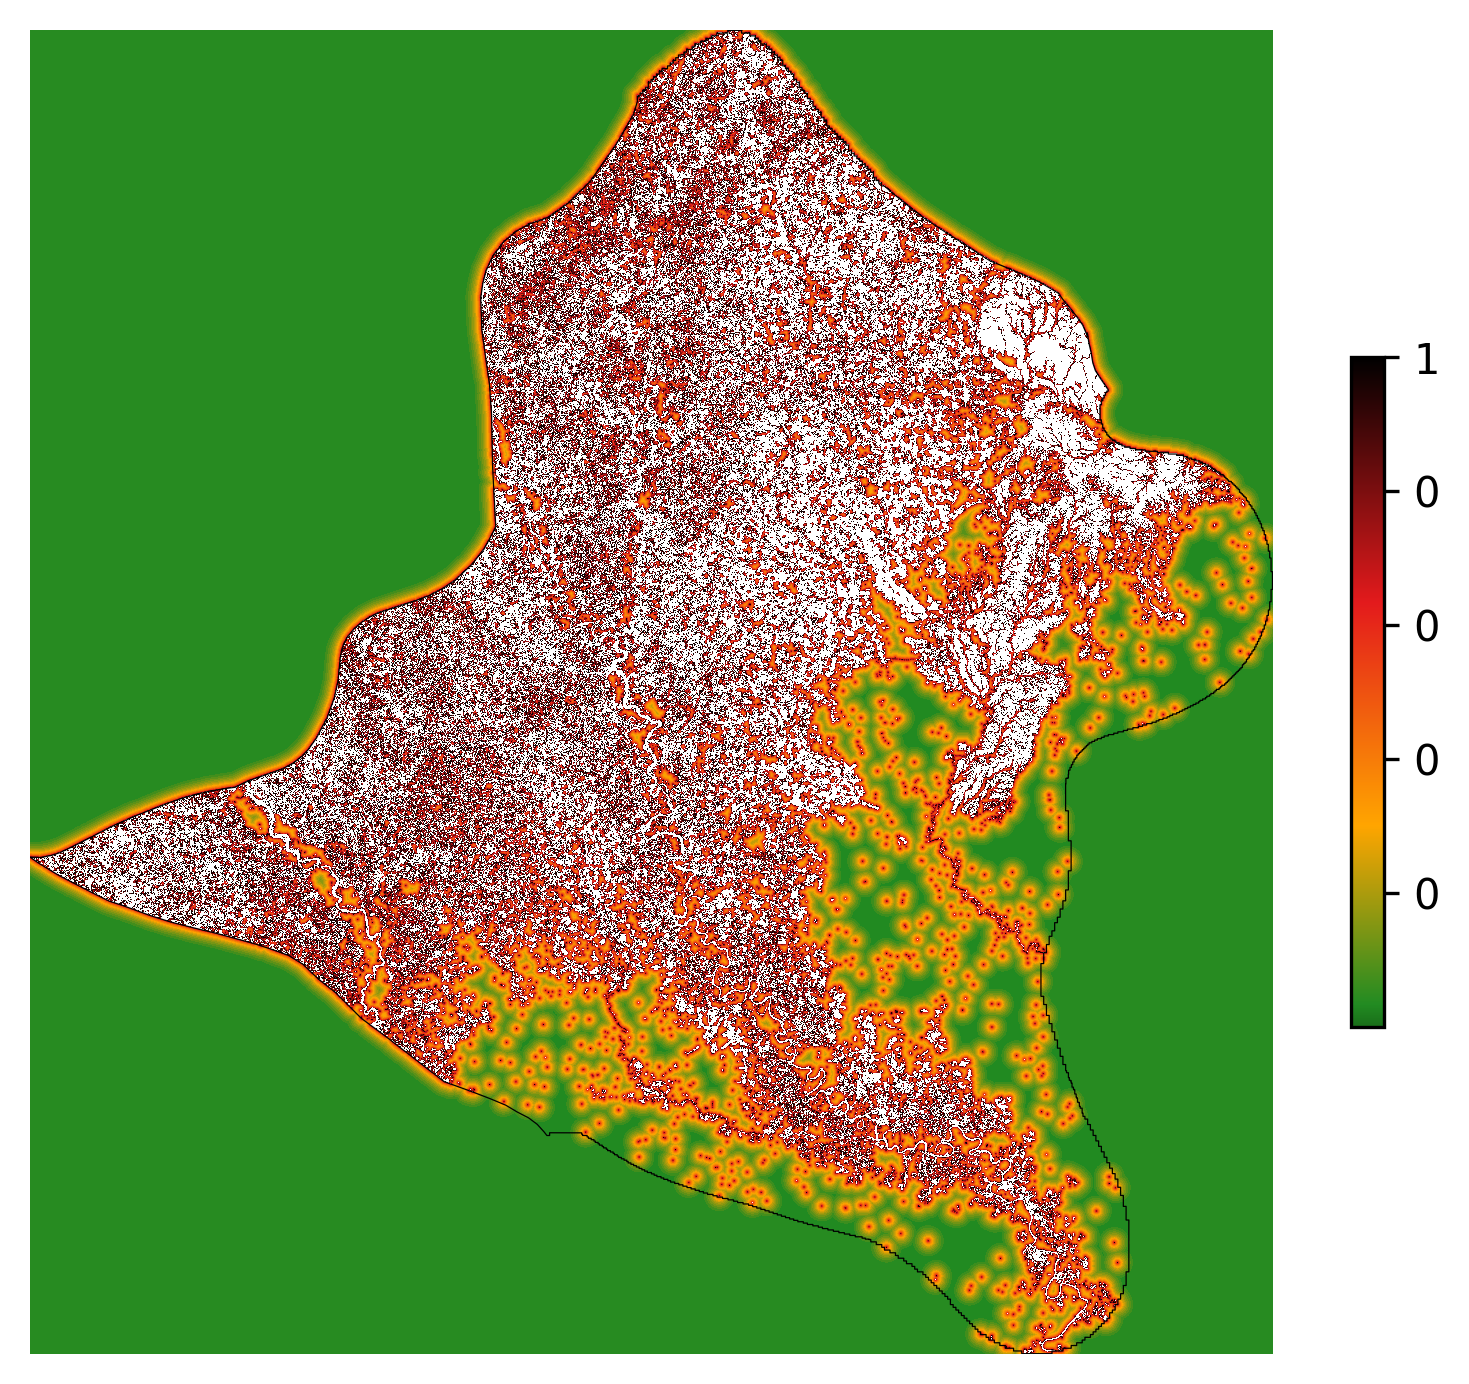

In [47]:
calculate_period_plot_risk_map(calibration_dict, aoi_vector, rmj_bm, plots_folder)


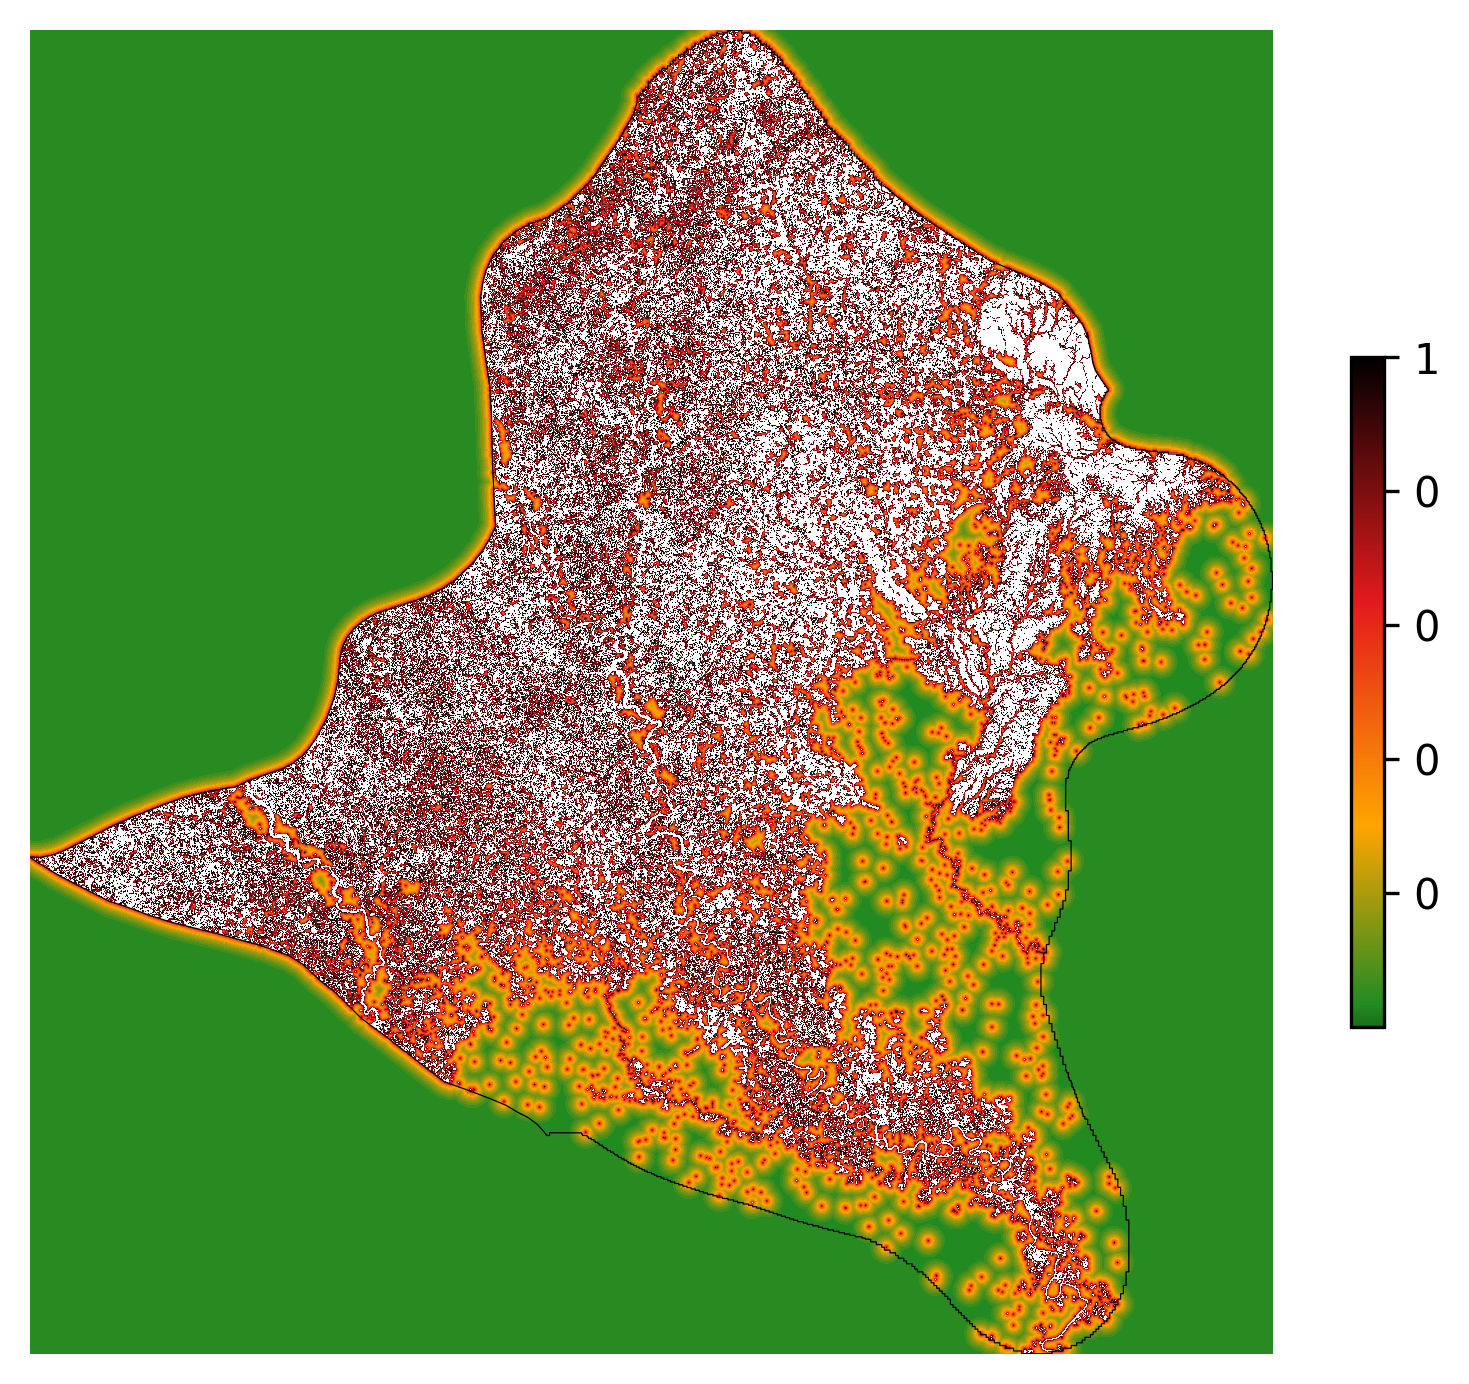

In [48]:
calculate_period_plot_risk_map(historical_dict, aoi_vector, rmj_bm, plots_folder)


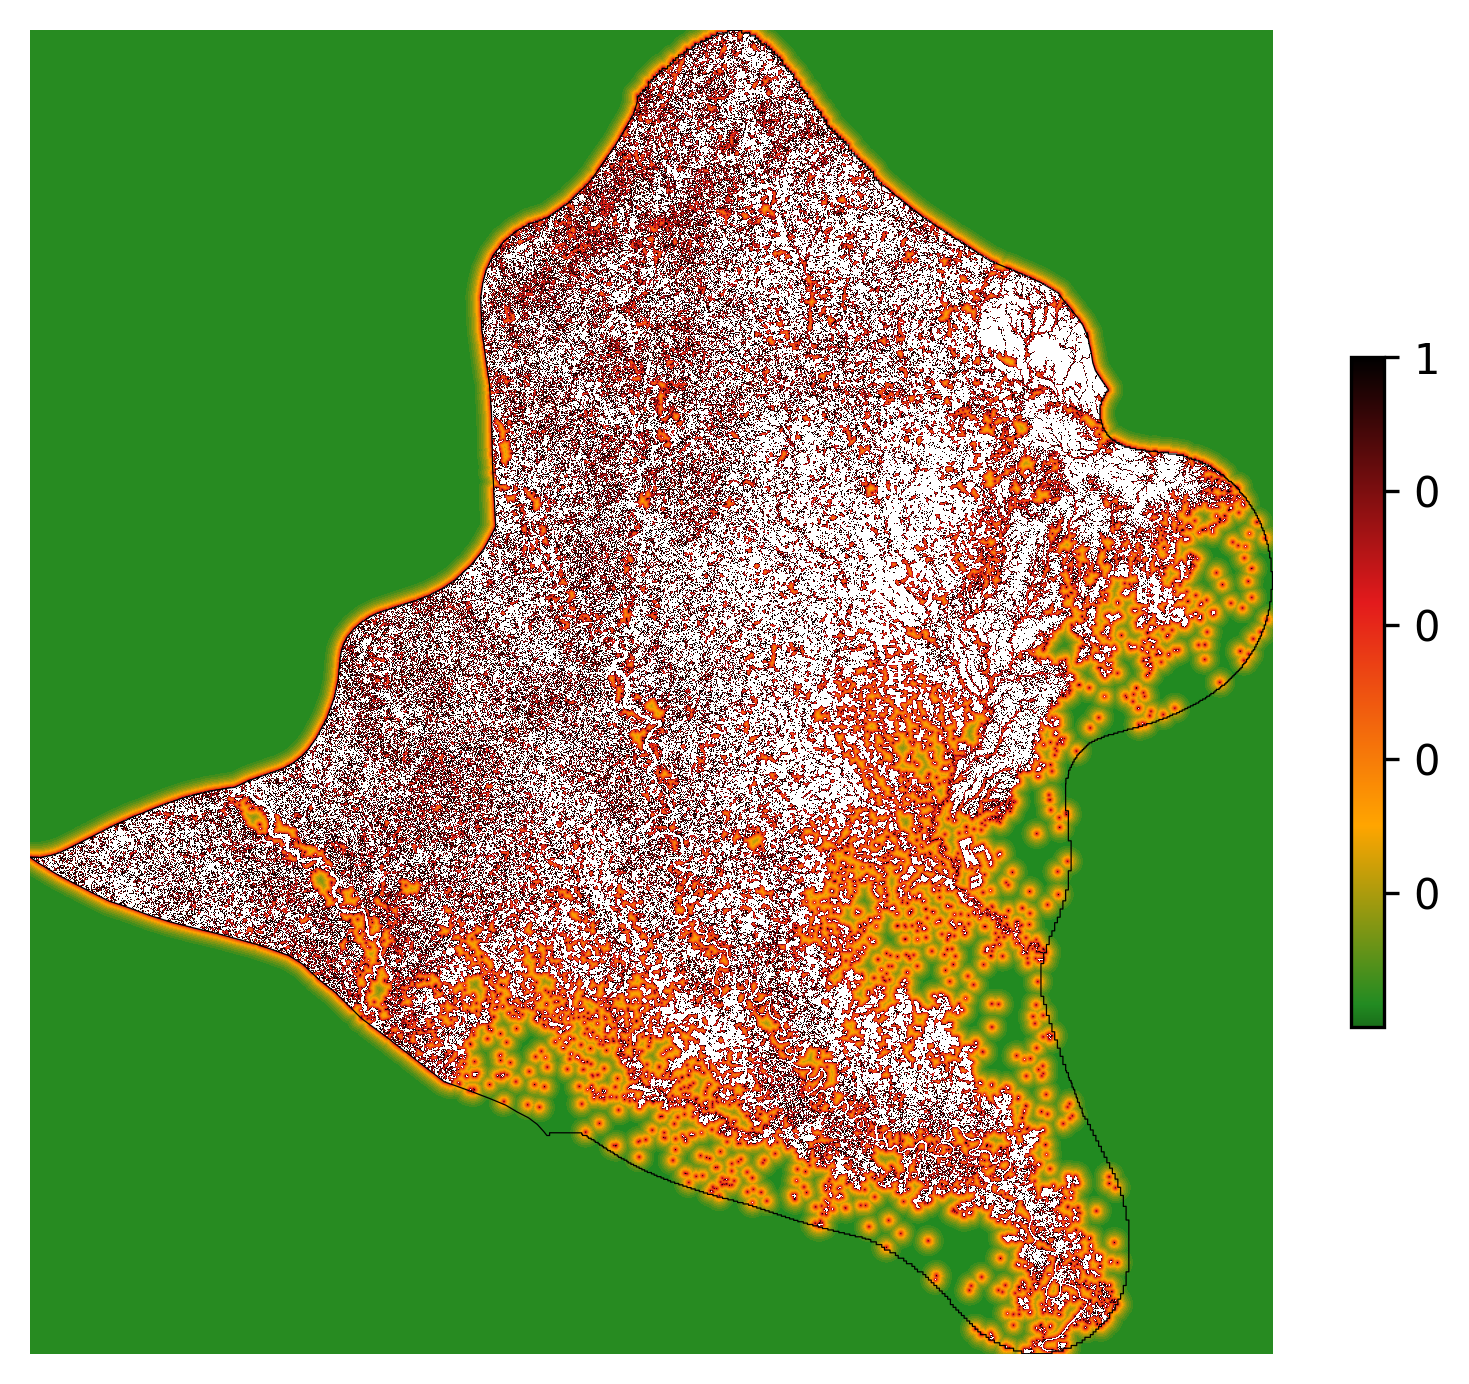

In [49]:
calculate_period_plot_risk_map(validation_dict, aoi_vector, rmj_bm, plots_folder)


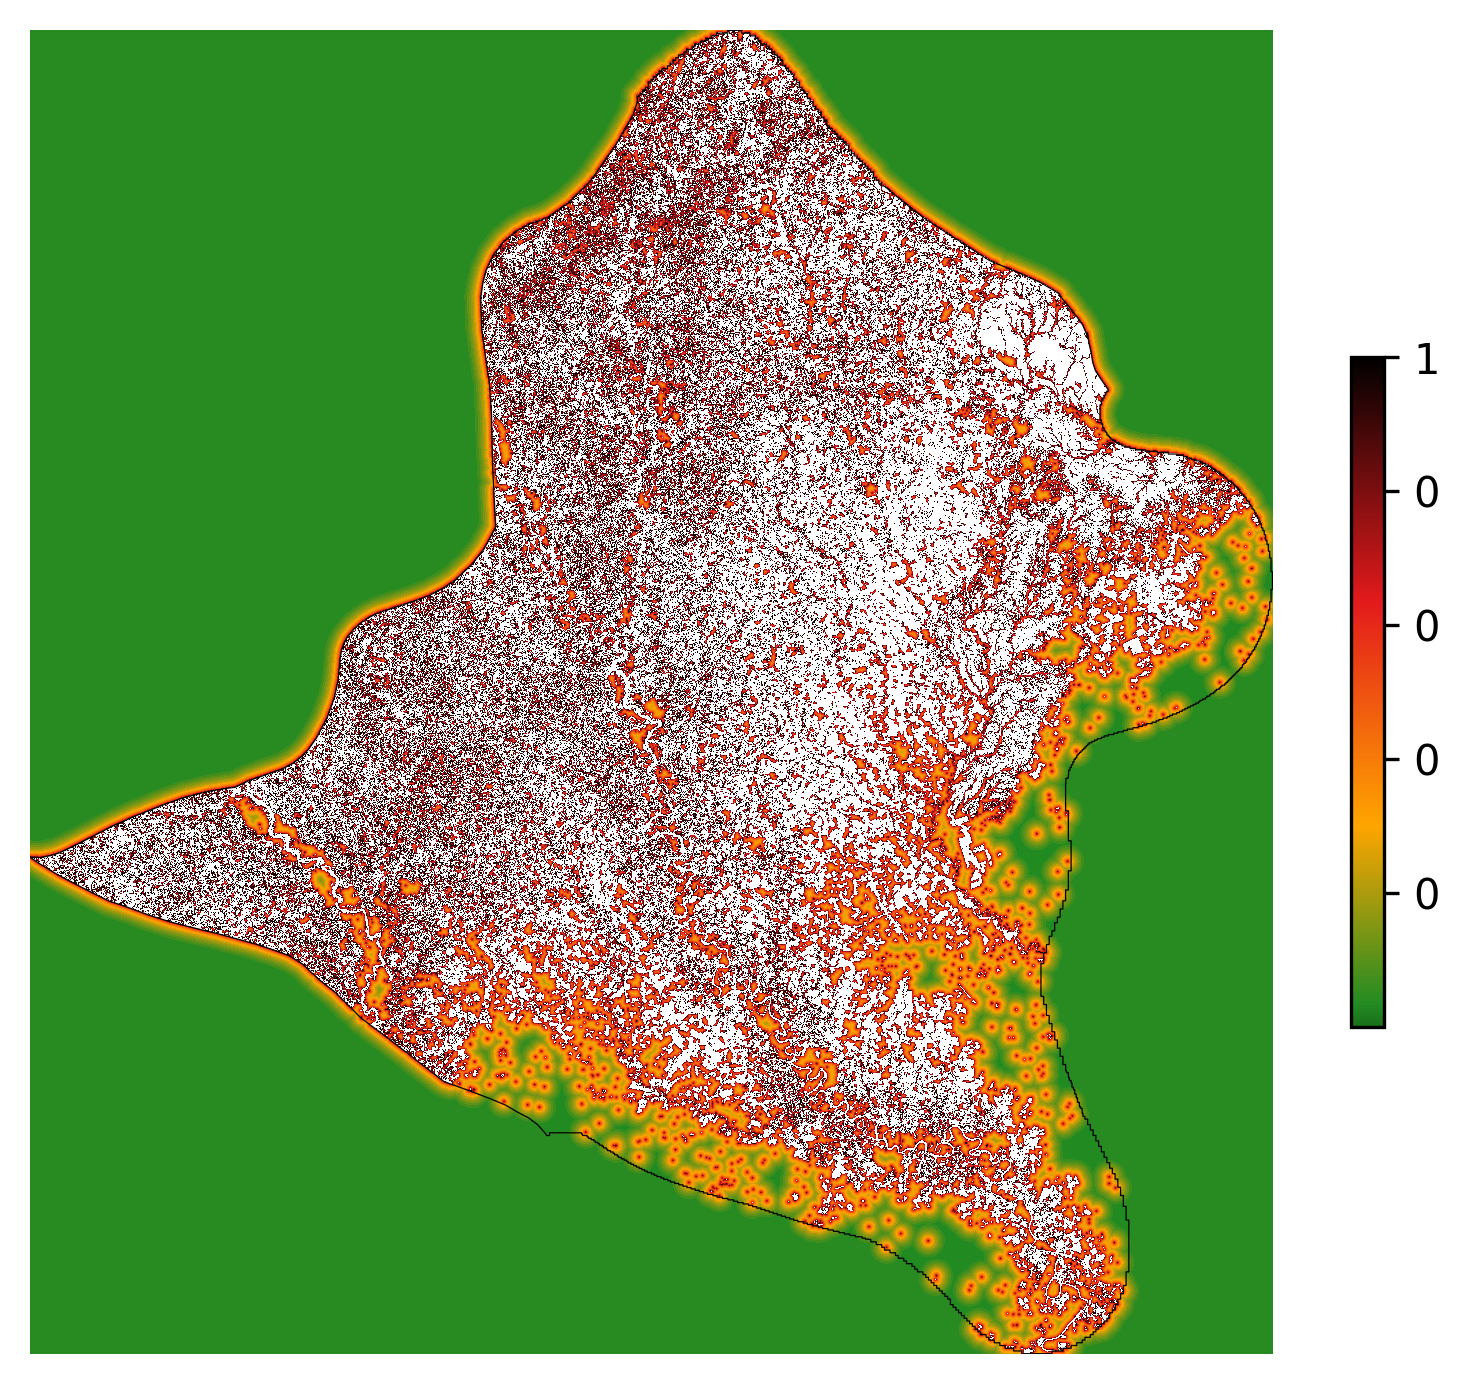

In [50]:
calculate_period_plot_risk_map(forecast_dict, aoi_vector, rmj_bm, plots_folder)
